In [3]:
import scipy
#import pytrends
#from pytrends.request import TrendReq
from numpy import random
import matplotlib.pyplot as plt
from scipy import optimize
import sys
import time
import pandas as pd
import seaborn as sns
import numpy as np
from pandas.io.json import json_normalize
import json
from datetime import datetime, timedelta
from county_spending import get_county_spending, spend_county_state_map, us_state_abbrev, abbrev_us_state, geo_search
from ACS_data import colname_mask
import re
import pickle
import requests
pd.set_option('display.max_columns', None)
import statsmodels.api as sm


In [2]:
class endpoint_graph():
    def __init__(self, gdict=None):
        if gdict==None:
            gdict = []
        self.gdict = gdict

    
        
        

In [3]:
# http://jeffreyfossett.com/2017/05/07/querying-usa-spending-python.html

# goal of this function is to get
# 1. Covid only relief spending (def_codes)
# 2. Filtered by department/agency
# 3. In a dream world we have businesses and hospital per county as well. 
#
# Can't get from api/v2/disaster need to go through api/v2/search

def post_usaspending_pages(query='agency', just_health=False):
    
    query_dict = {'agency':'/api/v2/disaster/agency/spending/',
                 'cfda':'/api/v2/disaster/cfda/spending/', # v long
                 'fed_acct':'/api/v2/disaster/federal_account/spending/',
                 'search_geo':'/api/v2/search/spending_by_geography/',
                 'toptier':'/api/v2/references/toptier_agencies/',
                 'dis_geo':'/api/v2/disaster/spending_by_geography/'}
    
    q = query_dict[query]

    # initialization
    has_next_page = True
    page = 1
    output = []

    while has_next_page:
        payload =  {
      "filter": {
          "def_codes": ["L", "M", "N", "O", "P", "U"]
      },
      "geo_layer": "county",
     # "geo_layer_filters": ["NE", "WY", "CO", "IA", "IL", "MI", "IN", "TX"],
      "scope": "recipient_location",
      "spending_type": "total",
      "pagination": {
                  "limit": 10,
                  "page": page,
                  "sort": "award_count",
                  "order": "desc"
              }
    }


        r = requests.post('https://api.usaspending.gov'+q, json=payload)
        rjson = r.json()
        output+= rjson['results']
        has_next_page = rjson['page_metadata']['hasNext']
        page+=1
        print(r.status_code, page)
    return output

def post_usaspending(query='agency', just_health=False):
    
    query_dict = {
                 'cfda':'/api/v2/disaster/cfda/spending/', # v long
                 'fed_acct':'/api/v2/disaster/federal_account/spending/',
                 'search_geo':'/api/v2/search/spending_by_geography/',
                 'toptier':'/api/v2/references/toptier_agencies/',
                 'dis_geo':'/api/v2/disaster/spending_by_geography/'}
    
    q = query_dict[query]

    # initialization
    has_next_page = True
    page = 1
    output = []

    payload =  {
  "filter": {
      "def_codes": ["L", "M", "N", "O", "P", "U"]
  },
  "geo_layer": "county",
 # "geo_layer_filters": ["NE", "WY", "CO", "IA", "IL", "MI", "IN", "TX"],
  "scope": "recipient_location",
  "spending_type": "obligation"
}


    r = requests.post('https://api.usaspending.gov'+q, json=payload)
    rjson = r.json()
    output+= rjson['results']
    #has_next_page = rjson['page_metadata']['hasNext']
    #page+=1
    print(r.status_code)
    return output

In [4]:
has_next_page = True
page = 1
output = []

#while has_next_page:
payload = {
      "filter": {
          "def_codes": ["L", "M", "N", "O", "P", "U"],
          "award_type_codes": ["02", "03", "04", "05", "07", "08", "10", "06", "09", "11", "A", "B", "C", "D", "IDV_A", "IDV_B", "IDV_B_A", "IDV_B_B", "IDV_B_C", "IDV_C", "IDV_D", "IDV_E"]
      },
    #  "pagination": {
    #      "limit": 10,
    #      "page": page,
    #      "sort": "award_count",
    #      "order": "desc"
    #  },
      "spending_type": "total"
  }


r= requests.post('https://api.usaspending.gov/api/v2/disaster/agency/loans/', json=payload)
rjson = r.json()
#has_next_page = rjson['page_metadata']['hasNext']
#page+=1
output+=rjson#['results']


In [5]:
output

['detail']

In [47]:
post_usaspending('dis_geo')

200


[{'amount': 32848306171.16,
  'display_name': 'Los Angeles',
  'shape_code': '06037',
  'population': 10039107,
  'per_capita': 3272.03,
  'award_count': 747836},
 {'amount': 8909569577.95,
  'display_name': 'Miami-Dade',
  'shape_code': '12086',
  'population': 2716940,
  'per_capita': 3279.27,
  'award_count': 423598},
 {'amount': 27132210710.36,
  'display_name': 'Cook',
  'shape_code': '17031',
  'population': 5150233,
  'per_capita': 5268.15,
  'award_count': 398169},
 {'amount': 13480970276.03,
  'display_name': 'Harris',
  'shape_code': '48201',
  'population': 4713325,
  'per_capita': 2860.18,
  'award_count': 280146},
 {'amount': 6607328901.56,
  'display_name': 'Broward',
  'shape_code': '12011',
  'population': 1952778,
  'per_capita': 3383.55,
  'award_count': 226534},
 {'amount': 11492189568.89,
  'display_name': 'Orange',
  'shape_code': '06059',
  'population': 3175692,
  'per_capita': 3618.8,
  'award_count': 219404},
 {'amount': 20469118325.18,
  'display_name': 'New Y

In [6]:
response = post_usaspending_pages()
response

agencies = ['Department of Labor', 'Department of Veterans Affairs', 'Department of Transportation',
           'Department of Health and Human Services', 'Department of Education', 'Department of Housing and Urban Development']

agency_dict = {}
for i in response:
    if i['description'] in agencies:
        agency_dict[i['description']] = {'id':i['id'], 'code':i['code']}
agency_dict

200 2
200 3
200 4
200 5


{'Department of Education': {'id': 1068, 'code': '091'},
 'Department of Housing and Urban Development': {'id': 882, 'code': '086'},
 'Department of Health and Human Services': {'id': 806, 'code': '075'},
 'Department of Transportation': {'id': 731, 'code': '069'},
 'Department of Veterans Affairs': {'id': 561, 'code': '036'},
 'Department of Labor': {'id': 267, 'code': '1601'}}

{'Department of Education': {'id': 1068, 'code': '091'}, 'Department of Housing and Urban Development': {'id': 882, 'code': '086'}, 'Department of Health and Human Services': {'id': 806, 'code': '075'}, 'Department of Transportation': {'id': 731, 'code': '069'}, 'Department of Veterans Affairs': {'id': 561, 'code': '036'}, 'Department of Labor': {'id': 267, 'code': '1601'}}

In [6]:
print(agency_dict)

f = open('agency_dict.pkl', 'wb')
pickle.dump(agency_dict, f)
f.close()

{'Department of Education': {'id': 1068, 'code': '091'}, 'Department of Housing and Urban Development': {'id': 882, 'code': '086'}, 'Department of Health and Human Services': {'id': 806, 'code': '075'}, 'Department of Transportation': {'id': 731, 'code': '069'}, 'Department of Veterans Affairs': {'id': 561, 'code': '036'}, 'Department of Labor': {'id': 267, 'code': '1601'}}


In [7]:
dep_dict = {'health':'075', 'education':'091', 'housing':'086','labor':'1601','transport':'069','veterans':'036'}
x = ['health', 'education']
[dep_dict[i] for i in x]

['075', '091']

In [84]:
f=open('agency_dict.pkl', 'r+')
agency_dict = pickle.load(f)
agency_dict

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte

<BarContainer object of 38 artists>

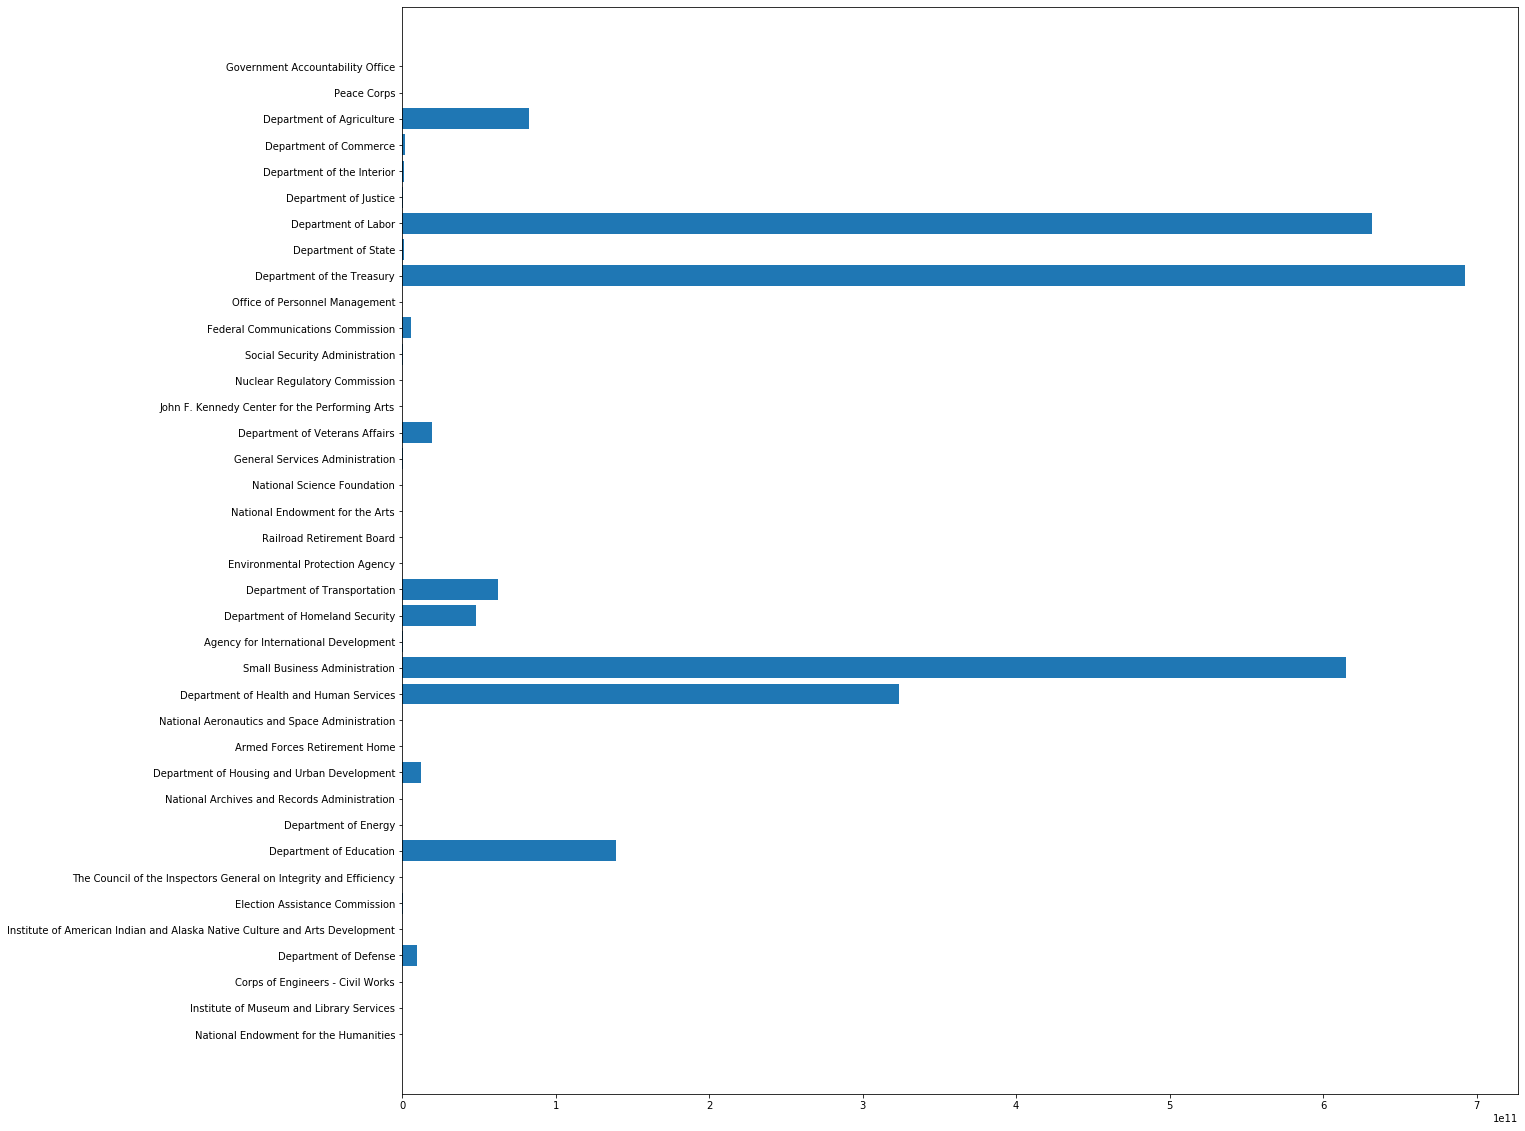

In [23]:
labels = [i['description'] for i in response]
awards = [i['total_budgetary_resources'] for i in response]
total_awards = np.sum(awards)

plt.figure(figsize=(20,20))
plt.barh(labels,awards)
#plt.xticks(rotation=90)


([<matplotlib.patches.Wedge at 0x7f1bf5eb7650>,
 [Text(1.0850719492038057, 0.18060693522413135, 'Department of Education'),
  Text(0.8318168300091979, 0.7197782723265891, 'Department of Health and Human Services'),
  Text(-0.2766616946532172, 1.0646399892506435, 'Small Business Administration'),
  Text(-1.0704838626798607, -0.2531092644333772, 'Department of the Treasury'),
  Text(0.25159159003232234, -1.070841571767275, 'Department of Labor'),
  Text(0.9690839801021607, -0.5204577211545193, 'Department of Agriculture'),
  Text(1.0786595011474276, -0.2156239332365097, 'Other')])

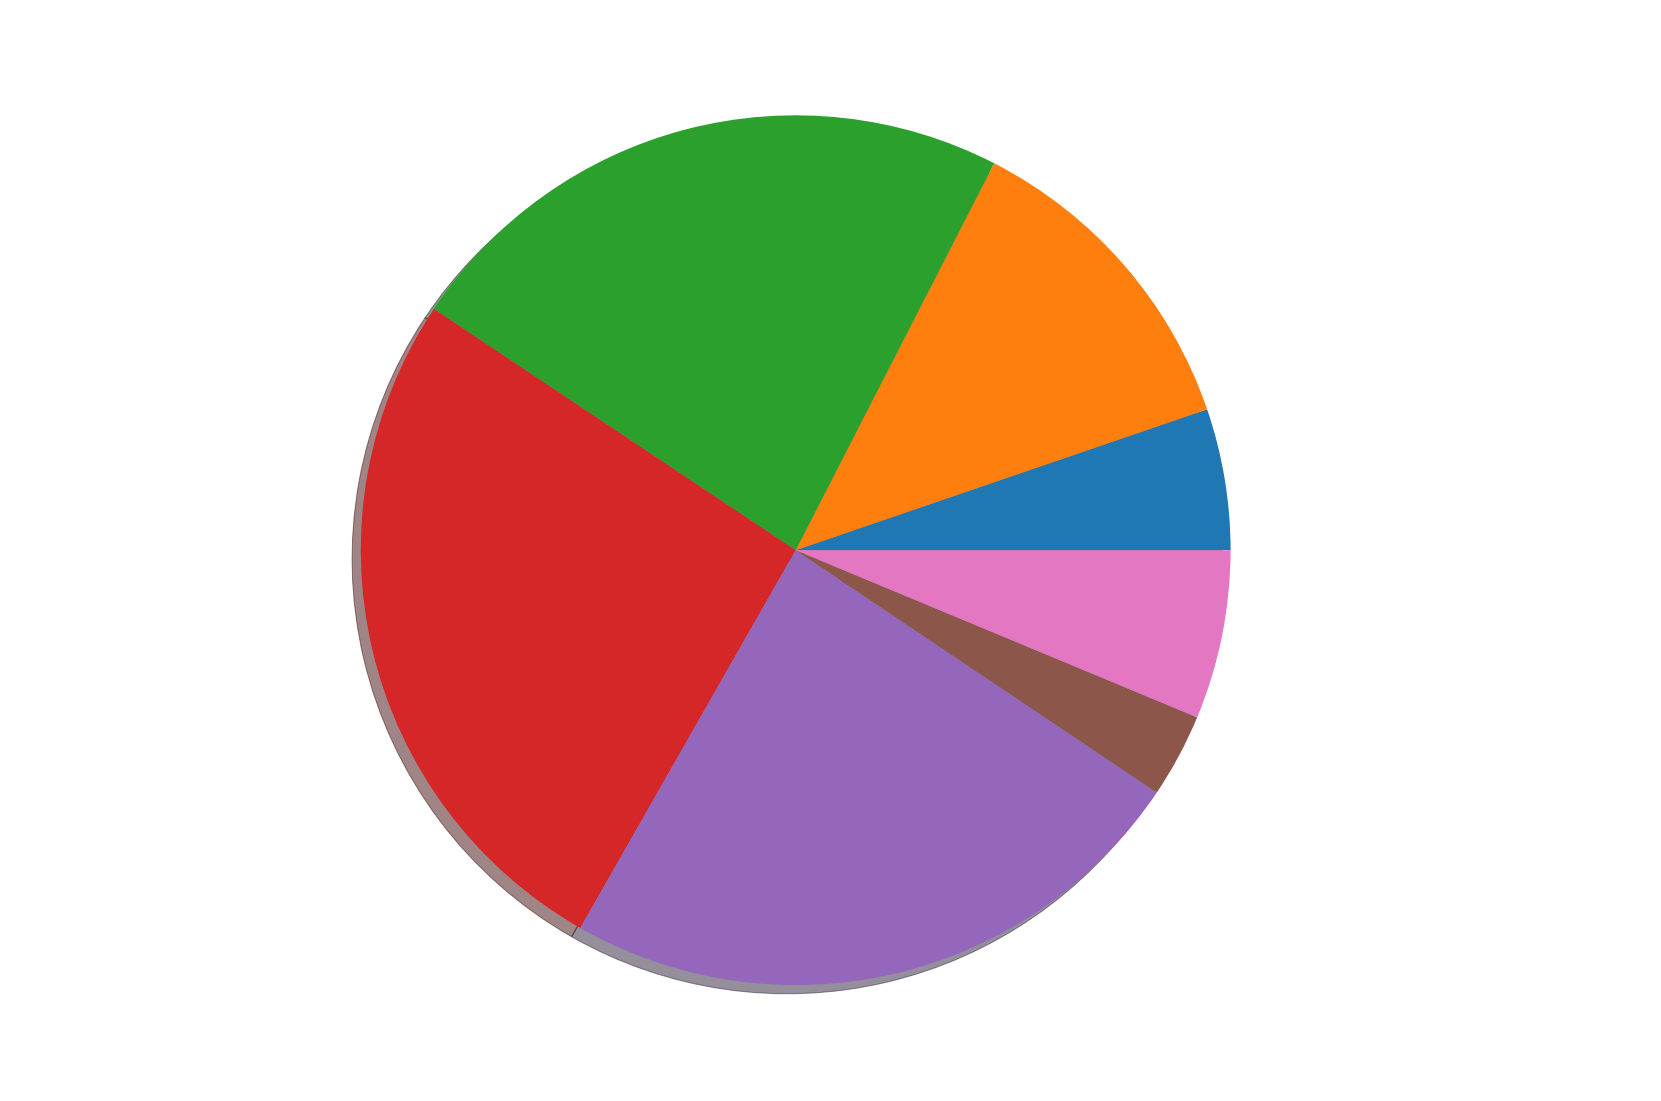

In [30]:
small_deps = 0
new_labels = []
new_awards = []

labels = [i['description'] for i in response]
awards = [i['total_budgetary_resources'] for i in response]
total_awards = np.sum(awards)

for idx, val in enumerate(awards):
    if val/total_awards > 0.03:
        new_labels.append(labels[idx])
        new_awards.append(awards[idx])
    else:
        small_deps += val
        
new_labels.append('Other')
new_awards.append(small_deps)
        
plt.figure(figsize=(20,20))
plt.pie(new_awards,labels=new_labels, shadow=True, textprops=dict(color="w", size=23))

In [86]:
agency_codes = [x['code'] for x in agency_dict.values()]
agency_codes

['091', '086', '075', '069', '036', '1601']

In [12]:
def geo_search_():
    
    q = '/api/v2/search/spending_by_geography/'

    # initialization
    has_next_page = True
    page = 1
    output = []

    #while has_next_page:
    payload =   {
  "filters": {
      #"tas_codes": [{
      #    "require":[["075"]]
      #}],
      "time_period":[{
          "start_date":"2020-02-06",
          "end_date":"2021-03-01"
      }]
  },

  "scope": "recipient_location",
  "geo_layer": "county"
}

    r = requests.post('https://api.usaspending.gov'+q, json=payload)
    print(r.text)
    rjson = r.json()
   # print(rjson)
    output+= rjson['results']
   # has_next_page = rjson['page_metad?ata']['hasNext']
    #page+=1
    print(r.status_code, page)
    return output

In [13]:
# With Dep Health Suffolk "aggregated_amount":19440707238.44
# With Dep Health Suffolk "aggregated_amount":172477803663.77
geo_dep_health = geo_search_()
#geo_dep_health = post_usaspending('dis_geo')


<html>
<head><title>504 Gateway Time-out</title></head>
<body>
<center><h1>504 Gateway Time-out</h1></center>
</body>
</html>



JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [7]:

init_data = {'shape_code': [i['shape_code'] for i in geo_dep_health[:]],
 'aggregated_amount': [i['aggregated_amount'] for i in geo_dep_health[:]],
 'display_name': [i['display_name'] for i in geo_dep_health[:]],
 'population': [i['population'] for i in geo_dep_health[:]],
 'per_capita': [i['per_capita'] for i in geo_dep_health[:]]}#,
 #'award_count': [i['award_count'] for i in geo_dep_health[:]]}


#init_data = geo_dep_health[0]
gdh_df = pd.DataFrame(data=init_data)


#gdh_df = pd.read_json(geo_dep_health.json())

NameError: name 'geo_dep_health' is not defined

In [126]:
gdh_df.head()

,shape_code,aggregated_amount,display_name,population,per_capita
0,01073,1.656807e+08,Jefferson,658573.0,251.58
1,48029,2.823625e+08,Bexar,2003554.0,140.93
2,18057,9.434972e+07,Hamilton,338011.0,279.13
3,24033,2.558395e+08,Prince George'S,909327.0,281.35
4,47037,9.238053e+07,Davidson,694144.0,133.09


In [13]:
### This cell has a working date filter, and apparently a useless TAS code filter
gdh_df.head()

,shape_code,aggregated_amount,display_name,population,per_capita
0,06037,1.203893e+11,Los Angeles,10039107.0,11992.03
1,12086,2.819816e+10,Miami-Dade,2716940.0,10378.65
2,17031,6.206278e+10,Cook,5150233.0,12050.48
3,06059,3.144932e+10,Orange,3175692.0,9903.14
4,17097,8.523876e+09,Lake,696535.0,12237.54


In [3]:
for i in gdh_df.columns[:21]:
    plt.scatter(np.log(gdh_df[i]), np.log(gdh_df['per_capita']))
    plt.title(i)
    plt.show()

NameError: name 'gdh_df' is not defined

Index(['Unnamed: 0', 'employed people with 16 yrs and over',
       'unemployed people with 16 yrs and over', 'people in the labor force',
       'unemployment rate', 'people with private health insurance',
       'people with public health insurance',
       'people without health insurance', 'people with a disability', 'male',
       'female', 'people that are older than 65', 'median household income',
       'median age', 'white', 'black or african american',
       'american indian and alaska native', 'asian',
       'native hawaiian and other pacific islander', 'hispanic or latino',
       'other races', 'county_name', 'State', 'tot', 'countyFIPS', 'StateFIPS',
       '2021-03-21', 'amount', 'shape_code', 'population', 'per_capita',
       'award_count'],
      dtype='object')


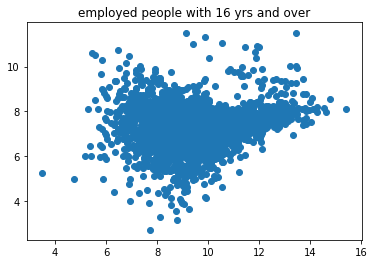

/home/hank/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


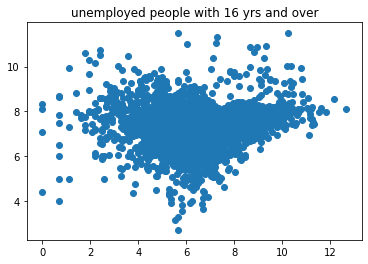

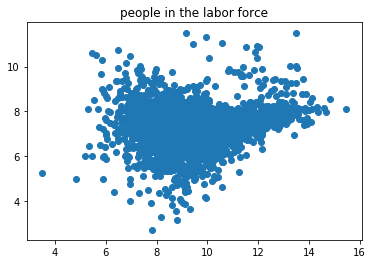

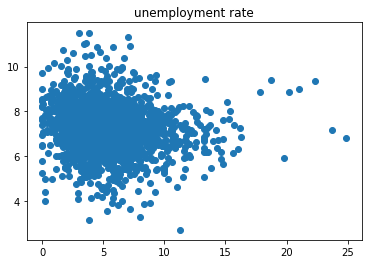

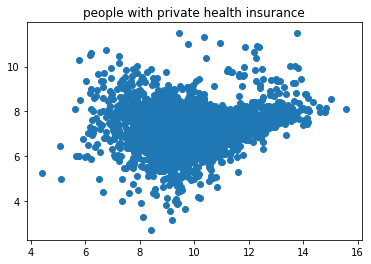

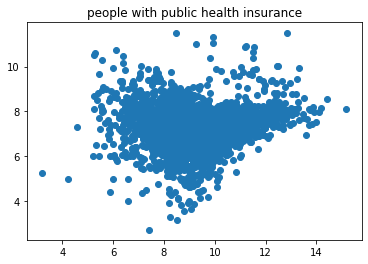

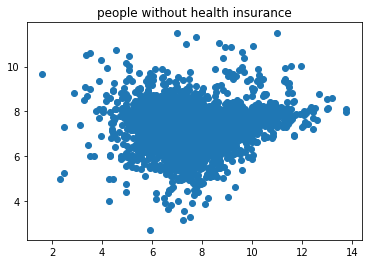

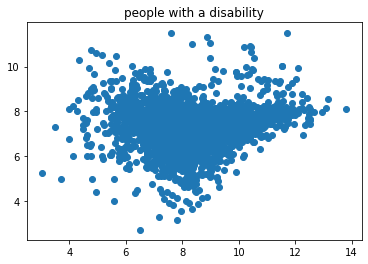

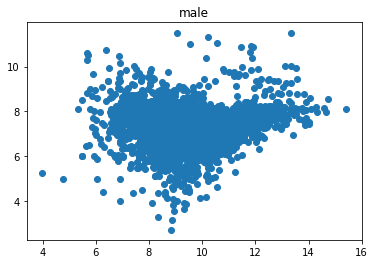

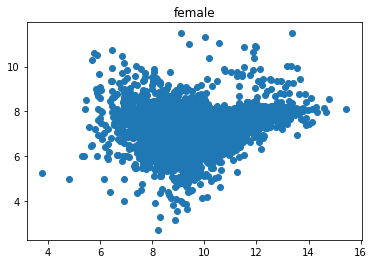

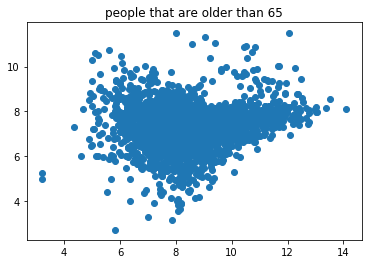

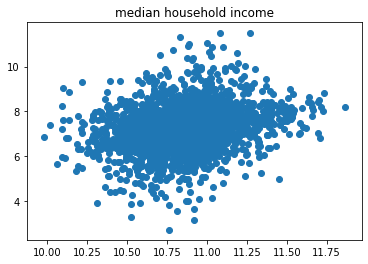

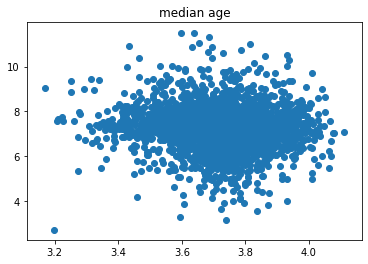

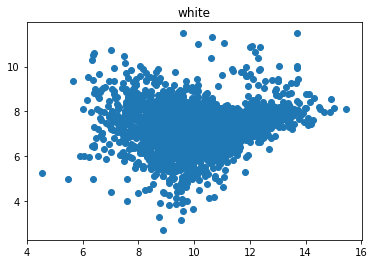

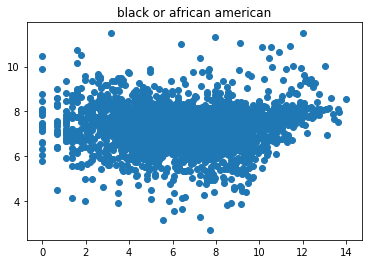

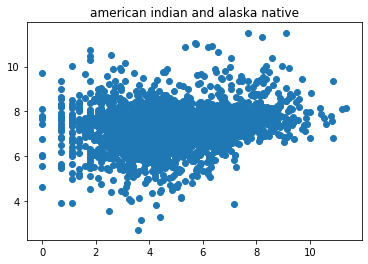

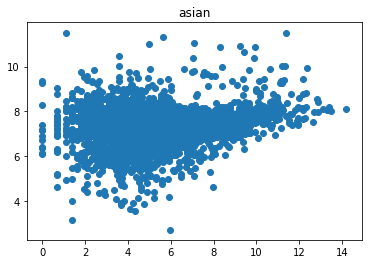

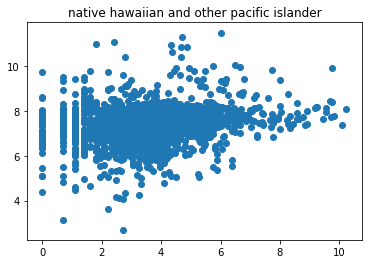

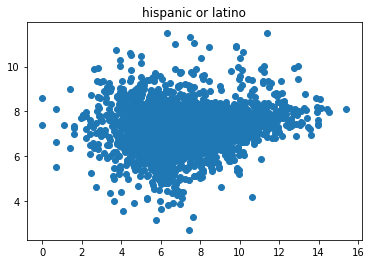

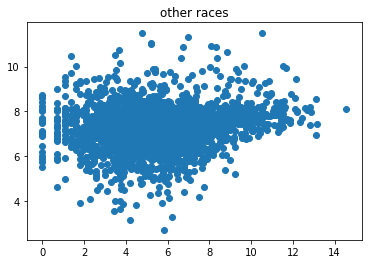

In [5]:
merged = pd.read_csv('merged_df.csv')
print(merged.columns)
for i in merged.columns[1:21]:
    if i == 'unemployment rate':
        plt.scatter(merged[i], np.log(merged['per_capita']))
        plt.title(i)
        plt.show()
    else:
        plt.scatter(np.log(merged[i]), np.log(merged['per_capita']))
        plt.title(i)
        plt.show()

In [43]:

def spend_county_state_map(spending, ACS, covid):
    spend = copy.deepcopy(spending)
    spend['State'] = ''
    val_count = spend['county_name'].value_counts()
    dupes = [i for i in val_count.index if val_count[i]!=1]
    for idx in spend.index:
        if spend.loc[idx, 'county_name'] in dupes:
            # Get a subset of the ACS data that matches entry county name
            ACS_sub = ACS[ACS['county_name']==spend.loc[idx, 'county_name']][['county_name','tot','State']]
            # calculate the difference between spend entry and ACS populations
            ACS_sub['diffs'] = np.abs(spend.loc[idx, 'population']-ACS_sub['tot'])
            # assign the lowest difference to the spending df
            #try:
            spend.loc[idx,'State']= ACS_sub[ACS_sub['diffs']==min(ACS_sub['diffs'])]['State'].values[0]
            #except:
                #spend.loc[idx,'State']= 'Missing'
                
            # Current implementation allows for multiple entries of the same county into different records
            # in the spending df which is impossible. Consider implementing a low pass filter with the
            # alternative case being unknown or a counter for number of assignments
            
        else:
            val = spend['county_name'][idx]
            #print(val)
            #print(covid[covid['county_name']==val].State.values[0])
            #print(spend.head())
           # try:
            spend.loc[idx, 'State'] = covid[covid['county_name']==val].State.values[0]
           # except:
                #spend.loc[idx, 'State'] = 'Missing'
    
    return spend


-------

In [5]:
newacs = pd.read_csv('newACS.csv', index_col=0)
merged_df = pd.read_csv('merged_df.csv', index_col=0)
joined = pd.read_csv('ACS5k_plus.csv', index_col=0)

In [17]:
merged_df.columns

Index(['employed people with 16 yrs and over',
       'unemployed people with 16 yrs and over', 'people in the labor force',
       'unemployment rate', 'people with private health insurance',
       'people with public health insurance',
       'people without health insurance', 'people with a disability', 'male',
       'female', 'people that are older than 65', 'median household income',
       'median age', 'white', 'black or african american',
       'american indian and alaska native', 'asian',
       'native hawaiian and other pacific islander', 'hispanic or latino',
       'other races', 'county_name', 'State', 'tot', 'countyFIPS', 'StateFIPS',
       '2021-03-21', 'amount', 'shape_code', 'population', 'per_capita',
       'award_count'],
      dtype='object')

In [20]:
dir(merged_df['female'])

['T',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_TO_AXIS_NUMBER',
 '_HANDLED_TYPES',
 '__abs__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__long__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__pos__

(array([  13.,   55.,  197.,  611., 1008.,  719.,  224.,  101.,   34.,
           8.]),
 array([ 9.97599424, 10.16496339, 10.35393255, 10.5429017 , 10.73187085,
        10.92084   , 11.10980915, 11.2987783 , 11.48774745, 11.67671661,
        11.86568576]),
 <a list of 10 Patch objects>)

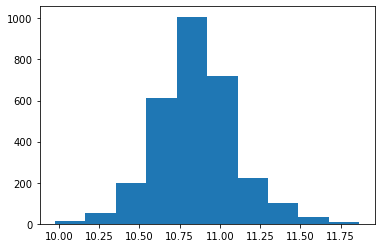

In [16]:
plt.hist((np.log(merged_df['median household income'])))

In [19]:
X_pop = merged_df.loc[:,['unemployed people with 16 yrs and over', 'people in the labor force',
       'people with public health insurance',
       'people without health insurance', 'people with a disability',
       'female', 'people that are older than 65',
       'black or african american', 'median household income',
       'american indian and alaska native', 'asian',
       'native hawaiian and other pacific islander', 'hispanic or latino',
       'other races', 'population']]

X_sanspop = merged_df.loc[:,['unemployed people with 16 yrs and over', 'people in the labor force',
       'people with public health insurance',
       'people without health insurance', 'people with a disability',
       'female', 'people that are older than 65',
       'black or african american',
       'american indian and alaska native', 'asian',
       'native hawaiian and other pacific islander', 'hispanic or latino',
       'other races']]

# Default value will be employed white male with private health insurance
defaults = ['white', 'male', 'employed people with 16 yrs and over', 'people with private health insurance']

pop_array = np.array(merged_df['population'])
#X = X.apply(lambda x: np.log(x), axis=1)
X_pop = X_pop.apply(lambda x: np.log(x), axis=0)
X_pop = X_pop.apply(lambda x: [0 if i==-np.inf else i for i in x])
X_pop['unemployment_rate'] = merged_df['unemployment rate']
X_pop['median_age'] = merged_df['median age']
X_pop['constant'] = 1

X_sanspop = X_sanspop.apply(lambda x: x/pop_array, axis = 0)
#X_sanspop = X_sanspop.apply(lambda x: np.log(x), axis=0)
#X_sanspop = X_sanspop.apply(lambda x: [0 if i==-np.inf else i for i in x])
X_sanspop['unemployment_rate'] = merged_df['unemployment rate']
X_sanspop['median_age'] = merged_df['median age']
X_sanspop['median household income'] = np.log(merged_df['median household income'])
X_sanspop['constant'] = 1



#X['median_household_income'] = np.log(merged_df['median household income'])

y1 = np.log(merged_df['per_capita'])
y2 = np.log(merged_df['2021-03-21'])

/home/hank/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [20]:
amount = sm.OLS(y1, X_pop).fit()
covid19= sm.OLS(y2, X_pop).fit()

print(amount.summary())
print(covid19.summary())

                            OLS Regression Results                            
Dep. Variable:             per_capita   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     29.35
Date:                Sat, 01 May 2021   Prob (F-statistic):           1.72e-87
Time:                        13:31:00   Log-Likelihood:                -3613.8
No. Observations:                2970   AIC:                             7264.
Df Residuals:                    2952   BIC:                             7372.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [21]:
amount = sm.OLS(y1, X_sanspop).fit()
covid19= sm.OLS(y2, X_sanspop).fit()

print(amount.summary())
print(covid19.summary())

                            OLS Regression Results                            
Dep. Variable:             per_capita   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     35.84
Date:                Sat, 01 May 2021   Prob (F-statistic):          1.50e-101
Time:                        13:31:59   Log-Likelihood:                -3582.2
No. Observations:                2970   AIC:                             7198.
Df Residuals:                    2953   BIC:                             7300.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

In [24]:

from sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np
x_array = np.asarray(X_pop)
normalized_arr = preprocessing.normalize(x_array)
df_norm= pd.DataFrame(x_array)

pca = PCA(n_components=18, svd_solver='full')
pca.fit(df_norm)
#print(pca.components_)
#print(pca.explained_variance_ratio_)
#print(len(pca.components_[0]))
for i in range(len(pca.components_[0])):
    print(X_pop.columns[i], pca.components_[0][i])

unemployed people with 16 yrs and over 0.2141880473212557
people in the labor force 0.18943374643902872
people with public health insurance 0.17363126463857323
people without health insurance 0.1885133975190596
people with a disability 0.1697639337645598
female 0.18596061477845846
people that are older than 65 0.16041921435760292
black or african american 0.30707861517719315
median household income 0.01132838199921793
american indian and alaska native 0.20710378240697971
asian 0.31491804434157517
native hawaiian and other pacific islander 0.22281636063658009
hispanic or latino 0.25967849399477233
other races 0.29598459656830106
population 0.18490641445160608
unemployment_rate 0.06433812721085583
median_age -0.5328321337791734
constant 0.0


In [25]:
VIFs = []
for i in X_pop.columns:
    tmp_x = X_pop.drop(columns = [i])
    tmp_y = X_pop[i]
    tmp_x['constant'] = 1
    tmp_fit = sm.OLS(tmp_y,tmp_x).fit()
    VIFs.append((1/(1-tmp_fit.rsquared)))

for idx in range(len(VIFs)):
    print(X_pop.columns[idx], VIFs[idx])

unemployed people with 16 yrs and over 46.02554574699258
people in the labor force 403.9418930818085
people with public health insurance 180.9077285945432
people without health insurance 16.457592685211512
people with a disability 78.89679750419093
female 1026.8561580075736
people that are older than 65 251.27727110531566
black or african american 3.857088753245531
median household income 4.90671240569861
american indian and alaska native 2.2166202698323025
asian 6.465735463682223
native hawaiian and other pacific islander 2.3698736154718754
hispanic or latino 8.776905422179615
other races 5.880265822008751
population 175.02145872870068
unemployment_rate 5.07351182907999
median_age 6.811947769788352
constant 0.0


/home/hank/miniconda3/envs/mlenv2020/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
